Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

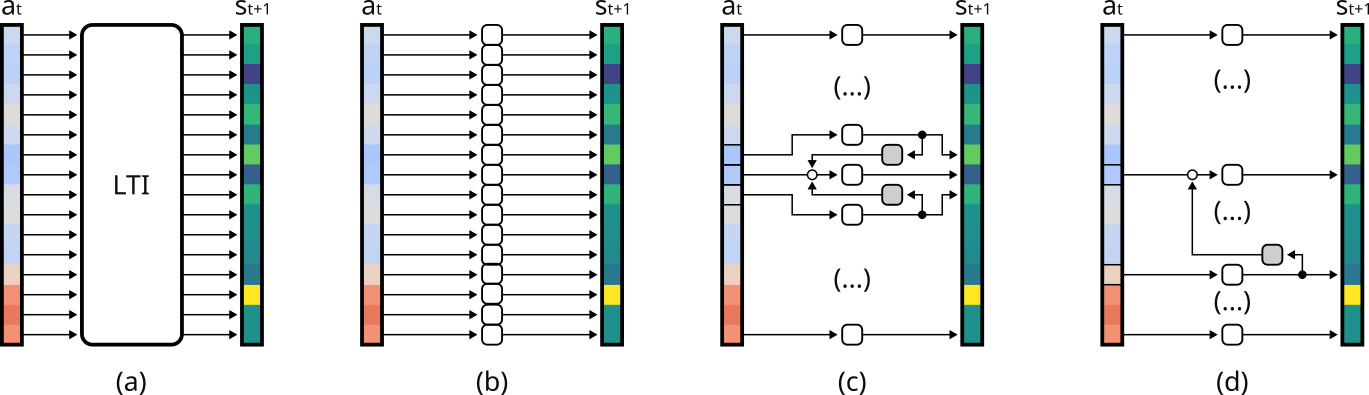

In [37]:
!pip3 install control --quiet

In [38]:
import numpy as np, pylab as plt
import control as ct, cv2

from scipy.ndimage import gaussian_filter
import matplotlib.animation as animation

from matplotlib import rc
rc('animation', html='jshtml')

# SPDL class

In [39]:
class SPDL_DB():
    def __init__(self, n=16, n_step=100, t=10):
        self.n = n
        self.n_step = n_step
        self.t = t
        # init
        self.N = n*n
        self.T = np.linspace(0, t, n_step)
        self.mode = None
        self.sys = None
        # spatial connection
        self.isconnected = None
        self.Qd = self.diffusion_map()
        self.isdiffuse = None

    def diffusion_map(self):
        # index link
        idx = np.arange(self.N).reshape((self.n,self.n))
        lleft = [str(l) + '.y' for l in np.roll(idx,1,axis=1).flatten()]
        lright = [str(l) + '.y' for l in np.roll(idx,-1,axis=1).flatten()]
        lup = [str(l) + '.y' for l in np.roll(idx,1,axis=0).flatten()]
        ldown = [str(l) + '.y' for l in np.roll(idx,-1,axis=0).flatten()]
        idx = idx.flatten()
        # Local Diffusion
        Q = [[str(i+self.N)+'.u']+[lleft[i]]+[lright[i]]+[lup[i]]+[ldown[i]] for i in idx]
        Q += [[str(i)+'.u']+[str(i+self.N)+'.y'] for i in idx]
        return tuple(map(tuple, tuple(Q)))

    def reset(self, mode=None, c=None, d=None) :
        self.mode = mode if mode != None else np.random.randint(3)
        # one complex system
        if self.mode == 0 :
          self.isconnected = None
          self.isdiffuse = None
          self.sys = ct.rss(states=4, outputs=self.N, inputs=self.N)
        # multiple simple system
        else :
          ss = []
          # connection
          self.isconnected = c if c != None else np.random.randint(2, dtype=bool)
          if self.isconnected :
            for i in range(self.N) :
              G = ct.TransferFunction([+1./(2*self.N)],[1]) # Gain loop
              G = ct.LinearIOSystem(G, name=str(self.N+i), inputs='u', outputs='y')
              ss += [G]
          # random system
          if self.mode == 1 :
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.rss(1), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # a/s+1
          else :
            a = 2*np.random.random((self.n,self.n)) - 1
            G = cv2.blur(a,(self.n,self.n))
            g = G.flatten() #g_2D = G.reshape(G.shape)
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.TransferFunction(g[i],[1,1]), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # interconnect (disjoint or not)
          in_ , out_ = [f'u[{i}]'  for i in range(self.N)], [f'y[{i}]'  for i in range(self.N)]
          inplist, outlist = [[f'{i}.u'] for i in range(self.N)], [[f'{i}.y'] for i in range(self.N)]
          if self.isconnected :
            self.isdiffuse = d if d != None else np.random.randint(2, dtype=bool)
            if self.isdiffuse : Q = self.Qd
            else :
              # randomized
              idx = np.arange(self.N)
              R = np.random.choice(idx, size=self.N, replace=False)
              # construct connection without Algebraic loop ([idx!=R])
              Q = [[str(i+self.N)+'.u']+[str(R[i]) + '.y'] for i in idx[idx!=R]]
              Q += [[str(i)+'.u']+[str(i+self.N)+'.y'] for i in idx[idx!=R]]
              Q = tuple(map(tuple, tuple(Q)))
          else :
            Q = None
          self.Q = Q
          self.sys = ct.InterconnectedSystem(ss, connections=Q, inplist=inplist, inputs=in_, outlist=outlist, outputs=out_)

    def step(self, smooth=None) :
        # initial state
        X0 = 2*np.random.random((self.N,1)) - 1
        ## random input for each time
        U_3D = 2*np.random.random((self.n, self.n,self.n_step)) - 1
        # smooth input in time (or not)
        self.smooth = smooth if smooth != None else np.random.randint(2, dtype=bool)
        U_3D = gaussian_filter(U_3D, (1., 1., 1.)) if self.smooth else U_3D
        U = U_3D.reshape((self.N,self.n_step))
        ## simulate
        if self.mode == 0 :
          T, yout, self.X = ct.forced_response(self.sys, T=self.T, U=U, X0=X0[:self.sys.nstates], return_x=True)
        else :
          T, yout, self.X = ct.input_output_response(self.sys, T=self.T, U=U, X0=X0, return_x=True)
        return U.T, yout.T

    def animate(self, S, RGB=False):
      fig, ax = plt.subplots()
      plt.axis('off')
      ims, i = [], 0
      for s in S :
        s_2D = s.reshape((self.n,self.n,3)) if RGB else s.reshape((self.n,self.n))
        blur = cv2.blur(s_2D,(3,3))
        im = ax.imshow(s_2D, animated=True)
        if i == 0 : ax.imshow(blur); i+=1
        ims.append([im])
      anim = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=True)
      return anim

# SPDL Database Contruct

## step test

In [40]:
spdl = SPDL_DB()#8)
spdl.reset(mode=1, c=True, d=False)
spdl.mode

1

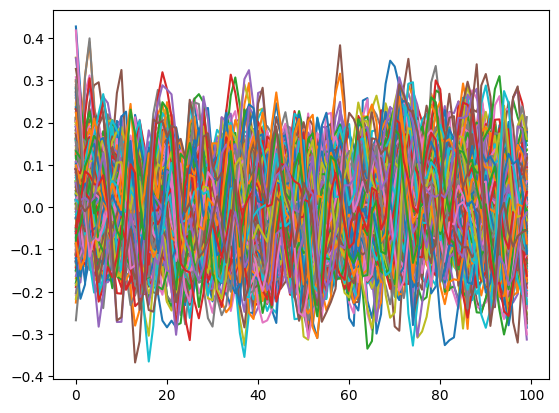

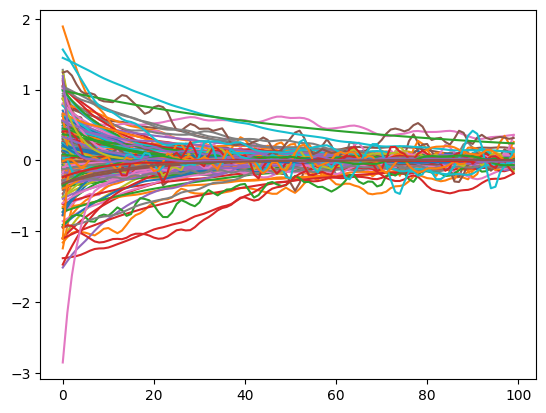

In [41]:
action, state = spdl.step(smooth=True)
plt.plot(action); plt.show()
plt.plot(state); plt.show()

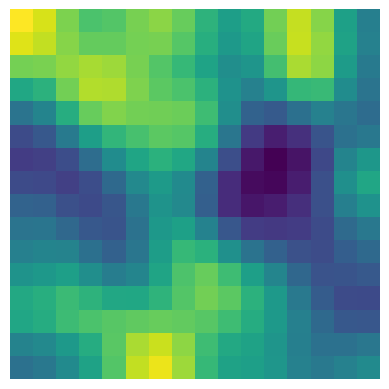

In [42]:
anim_a = spdl.animate(action)

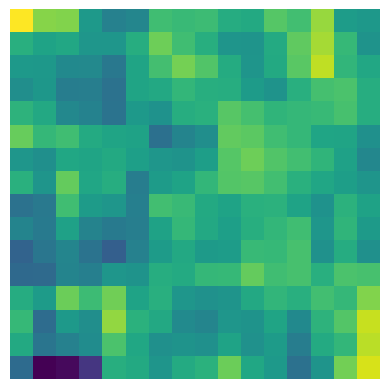

In [43]:
anim_s = spdl.animate(state)

## Construction d'une image pour diffusion

In [44]:
n, N,T = spdl.n, spdl.N, spdl.n_step

In [45]:
a = action.reshape((T,n,n,1))
s = state.reshape((T,n,n,1))

In [46]:
a = (((a - a.min()) / (a.max() - a.min())) * 255).astype(np.uint8)
s = (((s - s.min()) / (s.max() - s.min())) * 255).astype(np.uint8)

In [47]:
v = np.concatenate((a[1:], s[:-1], s[1:]), axis = 3) # bof (mettre une image 5D pour l'entrainement des UNet)

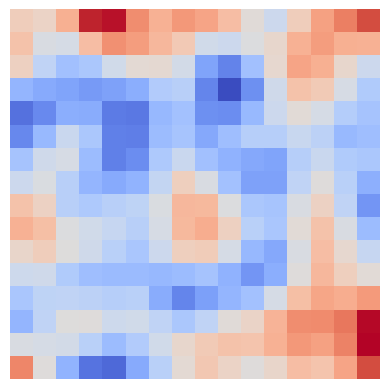

In [48]:
plt.imshow(a[6], cmap='coolwarm'); plt.axis('off'); plt.show()

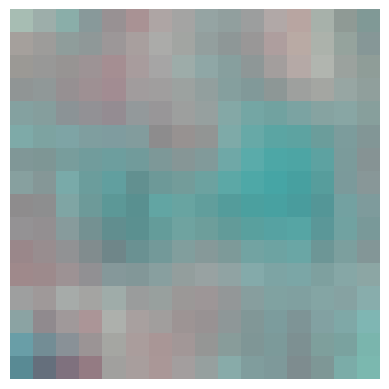

In [50]:
anim_rgb = spdl.animate(v, RGB=True) # bof

In [52]:
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"

Mounted at /content/drive


In [ ]:
"""
plt.imshow(s[0], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t-1).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(a[5], cmap='coolwarm'); plt.axis('off'); plt.savefig(dirpath+"example_a(t-1).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(s[6], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(a[6], cmap='coolwarm'); plt.axis('off'); plt.savefig(dirpath+"example_a(t).png", bbox_inches='tight', pad_inches=0); plt.show()
plt.imshow(s[-1], cmap='viridis'); plt.axis('off'); plt.savefig(dirpath+"example_s(t+1).png", bbox_inches='tight', pad_inches=0); plt.show()
"""

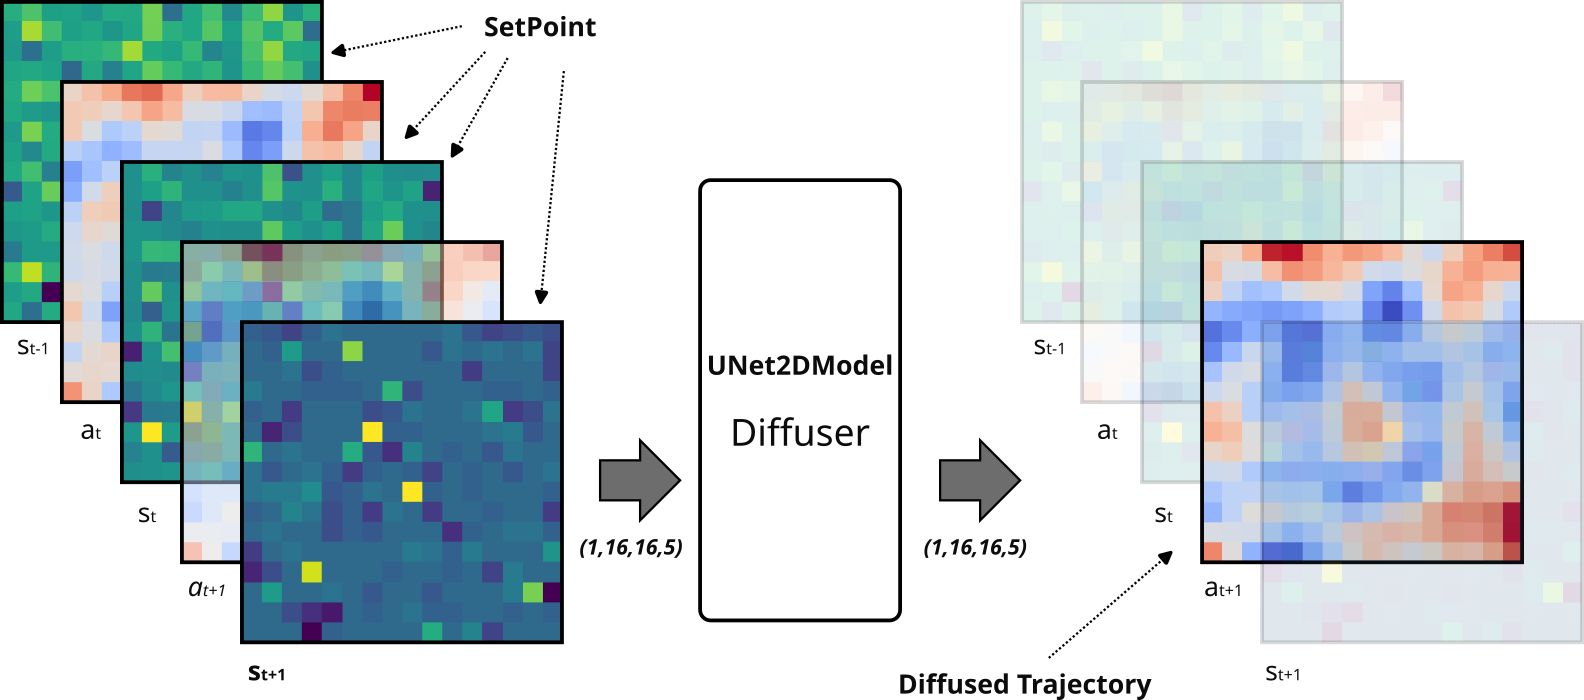

## Dataframe form (csv)

Voir si plutot DataLoader

In [51]:
columns = ["mode", "input_type", "spatial_connection", "step", "N", "index", "action", "previous_state", "state"]

## Source :


https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/?rdt=36200

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

https://diffusion-planning.github.io/

https://huggingface.co/docs/diffusers/tutorials/basic_training

Attention : Stable diffusion est different de diffusion, car espace latent : https://arxiv.org/abs/2112.10752 (impossible from scratch, uniquement pretrained https://www.databricks.com/blog/stable-diffusion-2 )

ici, juste un UNet : https://arxiv.org/abs/1505.04597

https://github.com/opendilab/awesome-diffusion-model-in-rl

ici : Unconditional diffusion